# PushT Dataset Visualization

This notebook loads the converted PushT dataset as a ToyDataset and visualizes the 2D agent trajectories.


In [1]:

import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path

# Add paths for imports
REPO_ROOT = "/proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht"
REPO_ROOT = "/home/albi/Workspace/SpatialDecompositionPusht"
SPATIALDECOMP_PATH = os.path.join(REPO_ROOT, "spatialdecomposition")
if SPATIALDECOMP_PATH not in sys.path:
    sys.path.append(SPATIALDECOMP_PATH)

sys.path.extend([
    "/proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht/libero",
    "/proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht/robomimic",
    "/proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht/robosuite",
    "/proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht/spatialdecomposition",
    "/proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht/diffusion_policy",
])

from SpatialDecomposition.TwoD_table_play.data import ToyDataset

print("Imports successful!")


/home/albi/miniconda3/envs/SD_pusht/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0
[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/albi/Workspace/SpatialDecompositionPusht/robosuite/robosuite/scripts/setup_macros.py (macros.py:55)


Imports successful!


# Nick's Processing of The Segmented Dataset

In [12]:
# Load the segmented dataset
# segmented_path = os.path.join(REPO_ROOT, "datasets", "pusht_toy_dataset_segmented.npz")
# metadata_path = os.path.join(REPO_ROOT, "datasets", "pusht_toy_dataset_segmented_metadata.npz")
segmented_path = os.path.join(REPO_ROOT, "datasets", "pusht_toy_dataset_segmented_normalized.npz")
metadata_path = os.path.join(REPO_ROOT, "datasets", "pusht_toy_dataset_segmented_normalized_metadata.npz")

print(f"Loading segmented dataset from: {segmented_path}")

try:
    segmented_dataset = ToyDataset.from_file(segmented_path)
    print(f"✓ Segmented dataset loaded successfully!")
    print(f"  - Number of segments: {len(segmented_dataset)}")
    print(f"  - Trajectory shape: {segmented_dataset.trajectories.shape}")
    
    # Load metadata
    if os.path.exists(metadata_path):
        metadata_data = np.load(metadata_path, allow_pickle=True)
        segment_metadata = metadata_data['segment_metadata']
        print(f"✓ Metadata loaded: {len(segment_metadata)} segments")
        
        # Print segmentation statistics
        contact_segments = sum(1 for m in segment_metadata if m['contact_flag'])
        no_contact_segments = sum(1 for m in segment_metadata if not m['contact_flag'])
        print(f"  - Contact segments: {contact_segments}")
        print(f"  - No-contact segments: {no_contact_segments}")
        print(f"  - Average segment length: {np.mean([m['segment_length'] for m in segment_metadata]):.1f}")
        # print min and max of normalized data saved in the metadata
        print(f"  - Min of normalized data: {metadata_data['min_val']}")
        print(f"  - Max of normalized data: {metadata_data['max_val']}")
    else:
        print("✗ No metadata file found")
        segment_metadata = None
        
except Exception as e:
    print(f"✗ Error loading segmented dataset: {e}")
    segmented_dataset = None
    segment_metadata = None


Loading segmented dataset from: /home/albi/Workspace/SpatialDecompositionPusht/datasets/pusht_toy_dataset_segmented_normalized.npz
✓ Segmented dataset loaded successfully!
  - Number of segments: 1291
  - Trajectory shape: (1291, 64, 2)
✓ Metadata loaded: 1291 segments
  - Contact segments: 608
  - No-contact segments: 683
  - Average segment length: 19.5
  - Min of normalized data: [13.456424 32.938293]
  - Max of normalized data: [496.14618 510.9579 ]


In [9]:
# Check prerequisites for cell 4
print("Checking prerequisites for statistical comparison...")

# Check if required variables exist
if 'segmented_dataset' not in locals():
    print("❌ Error: segmented_dataset not found. Please run the previous cells first.")
    print("   Make sure to run cells 1, 2, and 3 before running this cell.")
    print("   The segmented_dataset should be loaded in cell 2.")
elif segmented_dataset is None:
    print("❌ Error: segmented_dataset is None. Please check if the dataset file exists.")
    print("   Expected file: /home/albi/Workspace/SpatialDecompositionPusht/datasets/pusht_toy_dataset_segmented.npz")
    print("   If the file doesn't exist, you may need to run the dataset conversion script first.")
elif 'transformed_datasets' not in locals():
    print("❌ Error: transformed_datasets not found. Please run cell 3 first.")
    print("   The transformed_datasets should be created in cell 3.")
else:
    print("✅ All prerequisites met! Proceeding with statistical comparison...")
    print(f"   - segmented_dataset: {type(segmented_dataset)} with {len(segmented_dataset)} segments")
    print(f"   - transformed_datasets: {list(transformed_datasets.keys())}")


Checking prerequisites for statistical comparison...
✅ All prerequisites met! Proceeding with statistical comparison...
   - segmented_dataset: <class 'SpatialDecomposition.TwoD_table_play.data.ToyDataset'> with 1291 segments
   - transformed_datasets: ['FIRST', 'LAST']


In [10]:
# Replicate load_local_toy_datasets transformation
import copy
from SpatialDecomposition.datasets import EndEffectorPoseFrame

def load_local_toy_datasets_demo(dataset, reference_frames):
    """
    Replicate the load_local_toy_datasets function from train_local_policy.py
    
    This function transforms trajectories to local coordinate frames based on 
    either the FIRST or LAST frame position.
    
    Args:
        dataset: ToyDataset instance
        reference_frames: List of EndEffectorPoseFrame enum values
        
    Returns:
        Dictionary mapping reference frame names to transformed datasets
    """
    all_sub_demos = {}
    
    for reference_frame in reference_frames:
        # Deep copy the dataset to avoid modifying the original
        local_dataset = copy.deepcopy(dataset)
        
        # Select reference position based on frame type
        # [N, T, D] -> select first or last timestep -> [N, D]
        batched_local_pose = {
            EndEffectorPoseFrame.FIRST: local_dataset.trajectories[..., 0, :],  # First frame
            EndEffectorPoseFrame.LAST: local_dataset.trajectories[..., -1, :],   # Last frame
        }[reference_frame]
        
        # Add back a time dimension for broadcasting: [N, D] -> [N, 1, D]
        batched_local_pose = batched_local_pose[..., None, :]
        
        # Transform trajectories to local coordinates by subtracting reference position
        # This is like "centering" the trajectory at the reference frame
        local_dataset.trajectories = -batched_local_pose + local_dataset.trajectories
        
        # Store with reference frame name as key
        all_sub_demos[reference_frame.name] = local_dataset
        
        # Make compatible with previous interface
        local_dataset.sub_task_id = reference_frame.name
    
    return all_sub_demos

# Test the transformation on our segmented dataset
if segmented_dataset is not None:
    print("=" * 60)
    print("TESTING load_local_toy_datasets TRANSFORMATION")
    print("=" * 60)
    
    # Define reference frames to test
    reference_frames = [EndEffectorPoseFrame.FIRST, EndEffectorPoseFrame.LAST]
    
    # Apply the transformation
    transformed_datasets = load_local_toy_datasets_demo(segmented_dataset, reference_frames)
    
    print(f"\n✓ Transformation complete!")
    print(f"  - Created {len(transformed_datasets)} local coordinate datasets")
    print(f"  - Reference frames: {list(transformed_datasets.keys())}")
    
    # Show statistics for each transformed dataset
    for frame_name, local_dataset in transformed_datasets.items():
        print(f"\n--- {frame_name} Reference Frame ---")
        print(f"  Dataset shape: {local_dataset.trajectories.shape}")
        print(f"  Sub-task ID: {local_dataset.sub_task_id}")
        
        # Analyze coordinate ranges after transformation
        trajs = local_dataset.trajectories
        print(f"  X range: [{np.min(trajs[..., 0]):.2f}, {np.max(trajs[..., 0]):.2f}]")
        print(f"  Y range: [{np.min(trajs[..., 1]):.2f}, {np.max(trajs[..., 1]):.2f}]")
        
        # For FIRST frame, all trajectories should start at (0, 0)
        # For LAST frame, all trajectories should end at (0, 0)
        if frame_name == "FIRST":
            first_positions = trajs[:, 0, :]
            print(f"  All start positions (should be ~0): mean={np.mean(np.abs(first_positions)):.6f}, "
                  f"max={np.max(np.abs(first_positions)):.6f}")
        elif frame_name == "LAST":
            last_positions = trajs[:, -1, :]
            print(f"  All end positions (should be ~0): mean={np.mean(np.abs(last_positions)):.6f}, "
                  f"max={np.max(np.abs(last_positions)):.6f}")
else:
    print("Segmented dataset not available for transformation")


TESTING load_local_toy_datasets TRANSFORMATION

✓ Transformation complete!
  - Created 2 local coordinate datasets
  - Reference frames: ['FIRST', 'LAST']

--- FIRST Reference Frame ---
  Dataset shape: (1291, 64, 2)
  Sub-task ID: FIRST
  X range: [-1.65, 1.58]
  Y range: [-1.46, 1.83]
  All start positions (should be ~0): mean=0.000000, max=0.000000

--- LAST Reference Frame ---
  Dataset shape: (1291, 64, 2)
  Sub-task ID: LAST
  X range: [-1.60, 1.46]
  Y range: [-1.83, 1.30]
  All end positions (should be ~0): mean=0.000000, max=0.000000


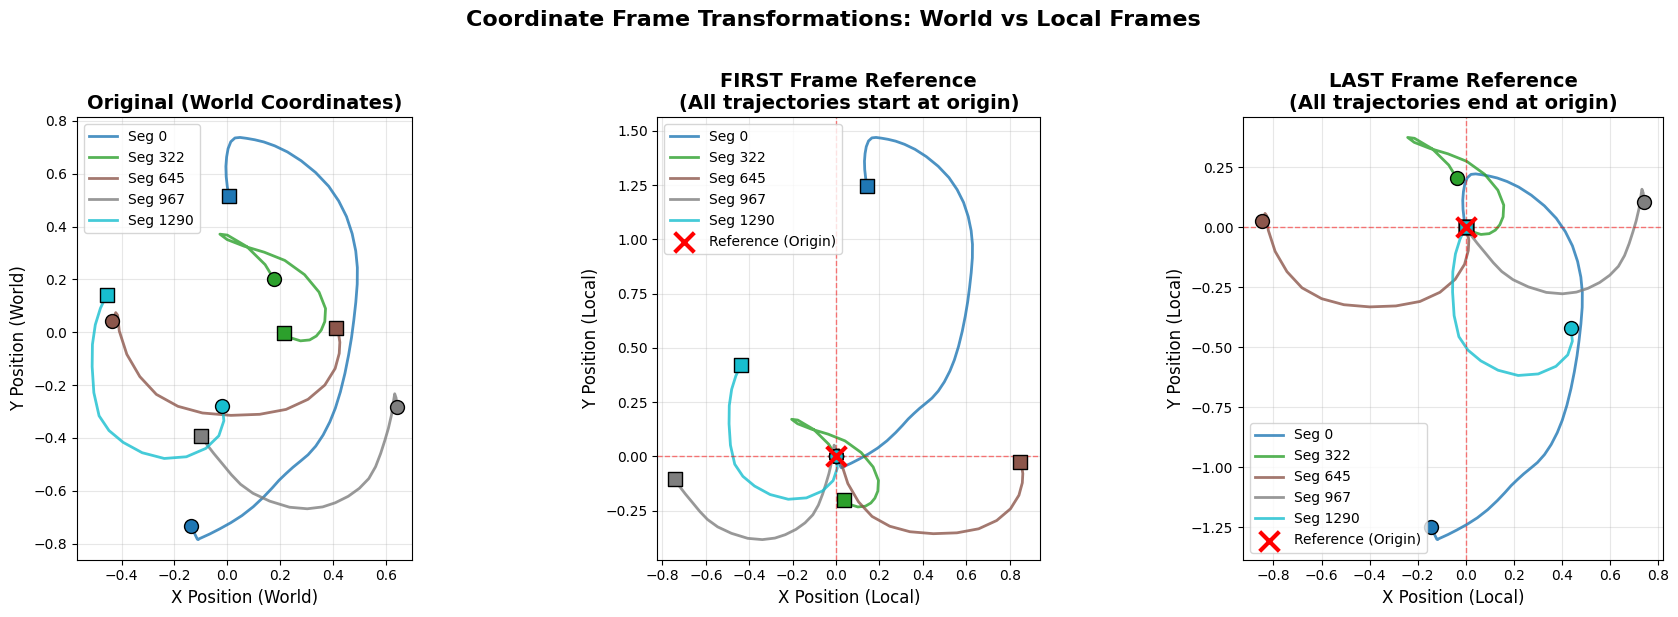


Visualization explanation:
- LEFT: Original world coordinates (as collected)
- MIDDLE: Transformed to FIRST frame reference (start at origin)
- RIGHT: Transformed to LAST frame reference (end at origin)

This transformation allows the model to learn policies in local coordinates,
making it easier to generalize across different spatial locations.


In [11]:
# Visualize original vs transformed trajectories
if segmented_dataset is not None and 'transformed_datasets' in locals():
    # Select a few sample trajectories to visualize
    n_samples = 5
    sample_indices = np.linspace(0, len(segmented_dataset)-1, n_samples, dtype=int)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Color palette for different samples
    colors = plt.cm.tab10(np.linspace(0, 1, n_samples))
    
    # Plot 1: Original (World) Coordinates
    ax = axes[0]
    for i, idx in enumerate(sample_indices):
        sample = segmented_dataset[idx]
        traj = sample.trajectory
        ax.plot(traj[:, 0], traj[:, 1], color=colors[i], linewidth=2, alpha=0.8, label=f'Seg {idx}')
        ax.scatter(traj[0, 0], traj[0, 1], color=colors[i], marker='o', s=100, edgecolors='black', zorder=5)
        ax.scatter(traj[-1, 0], traj[-1, 1], color=colors[i], marker='s', s=100, edgecolors='black', zorder=5)
    
    ax.set_xlabel('X Position (World)', fontsize=12)
    ax.set_ylabel('Y Position (World)', fontsize=12)
    ax.set_title('Original (World Coordinates)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_aspect('equal')
    
    # Plot 2: FIRST Frame Reference (all start at origin)
    ax = axes[1]
    first_dataset = transformed_datasets['FIRST']
    for i, idx in enumerate(sample_indices):
        sample = first_dataset[idx]
        traj = sample.trajectory
        ax.plot(traj[:, 0], traj[:, 1], color=colors[i], linewidth=2, alpha=0.8, label=f'Seg {idx}')
        ax.scatter(traj[0, 0], traj[0, 1], color=colors[i], marker='o', s=100, edgecolors='black', zorder=5)
        ax.scatter(traj[-1, 0], traj[-1, 1], color=colors[i], marker='s', s=100, edgecolors='black', zorder=5)
    
    # Mark the origin
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.scatter([0], [0], color='red', marker='x', s=200, linewidths=3, label='Reference (Origin)', zorder=10)
    
    ax.set_xlabel('X Position (Local)', fontsize=12)
    ax.set_ylabel('Y Position (Local)', fontsize=12)
    ax.set_title('FIRST Frame Reference\n(All trajectories start at origin)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_aspect('equal')
    
    # Plot 3: LAST Frame Reference (all end at origin)
    ax = axes[2]
    last_dataset = transformed_datasets['LAST']
    for i, idx in enumerate(sample_indices):
        sample = last_dataset[idx]
        traj = sample.trajectory
        ax.plot(traj[:, 0], traj[:, 1], color=colors[i], linewidth=2, alpha=0.8, label=f'Seg {idx}')
        ax.scatter(traj[0, 0], traj[0, 1], color=colors[i], marker='o', s=100, edgecolors='black', zorder=5)
        ax.scatter(traj[-1, 0], traj[-1, 1], color=colors[i], marker='s', s=100, edgecolors='black', zorder=5)
    
    # Mark the origin
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.scatter([0], [0], color='red', marker='x', s=200, linewidths=3, label='Reference (Origin)', zorder=10)
    
    ax.set_xlabel('X Position (Local)', fontsize=12)
    ax.set_ylabel('Y Position (Local)', fontsize=12)
    ax.set_title('LAST Frame Reference\n(All trajectories end at origin)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_aspect('equal')
    
    plt.suptitle('Coordinate Frame Transformations: World vs Local Frames', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization explanation:")
    print("- LEFT: Original world coordinates (as collected)")
    print("- MIDDLE: Transformed to FIRST frame reference (start at origin)")
    print("- RIGHT: Transformed to LAST frame reference (end at origin)")
    print("\nThis transformation allows the model to learn policies in local coordinates,")
    print("making it easier to generalize across different spatial locations.")
else:
    print("Transformed datasets not available for visualization")


STATISTICAL COMPARISON: Original vs Transformed Datasets

Metric                         | Original             | FIRST Frame          | LAST Frame          
-----------------------------------------------------------------------------------------------
Shape                          | (1291, 64, 2)        | (1291, 64, 2)        | (1291, 64, 2)       

--- Coordinate Ranges ---
X Range                        | [  13.5,  496.1] | [-397.4,  381.4] | [-386.5,  353.0]
Y Range                        | [  32.9,  511.0] | [-349.2,  438.0] | [-436.8,  310.8]

--- Start Position Statistics ---
Start X (mean ± std)           |  226.8 ±   96.2 |    0.0 ±    0.0 |    6.3 ±   92.8
Start Y (mean ± std)           |  294.8 ±   93.9 |    0.0 ±    0.0 |   -4.3 ±   99.1

--- End Position Statistics ---
End X (mean ± std)             |  220.6 ±   87.6 |   -6.3 ±   92.8 |    0.0 ±    0.0
End Y (mean ± std)             |  299.1 ±   83.8 |    4.3 ±   99.1 |    0.0 ±    0.0

--- Trajectory Displacement ---
Di

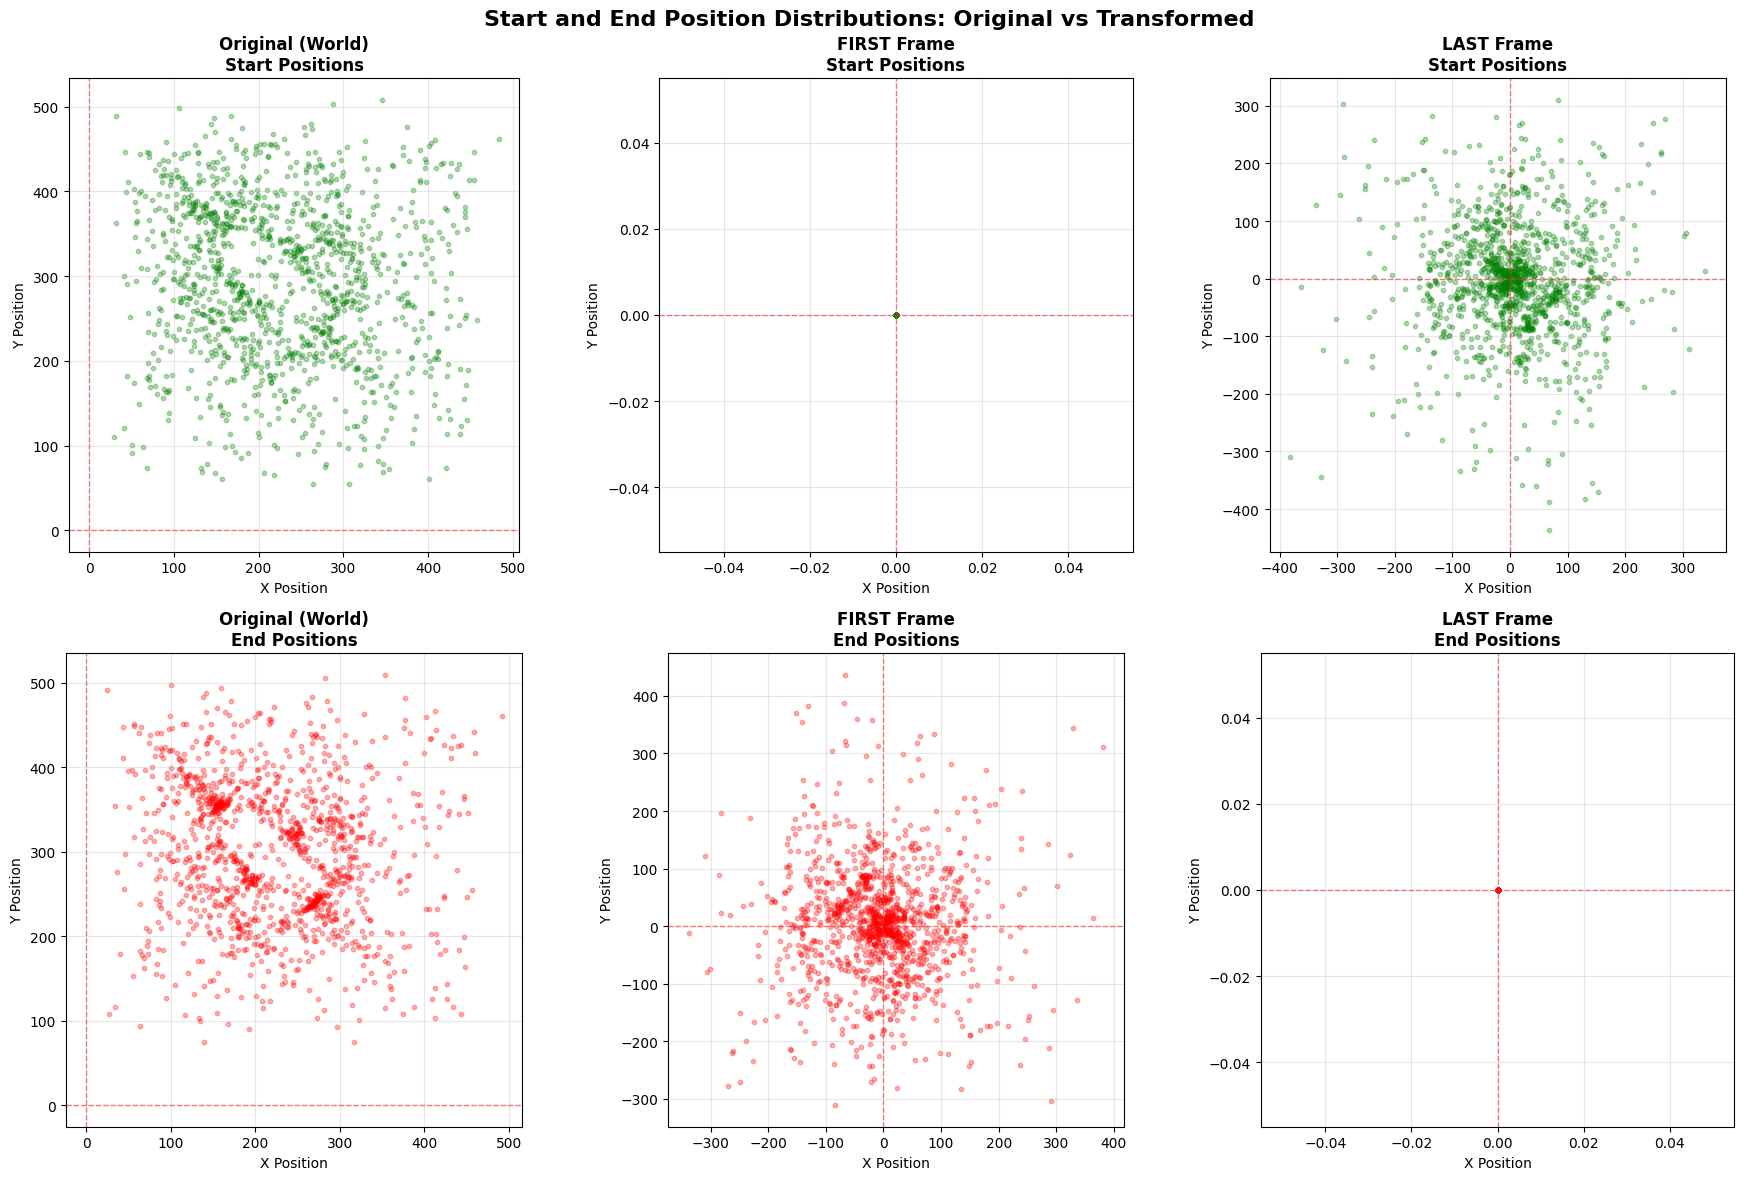

In [6]:
# Compare statistics: Original vs Transformed
if segmented_dataset is not None and 'transformed_datasets' in locals():
    print("=" * 80)
    print("STATISTICAL COMPARISON: Original vs Transformed Datasets")
    print("=" * 80)
    
    # Helper function to compute statistics
    def compute_stats(dataset, name):
        trajs = dataset.trajectories
        
        # Start and end positions
        start_pos = trajs[:, 0, :]  # [N, D]
        end_pos = trajs[:, -1, :]   # [N, D]
        
        # Displacement (from start to end)
        displacement = end_pos - start_pos  # [N, D]
        displacement_magnitude = np.linalg.norm(displacement, axis=-1)  # [N]
        
        # Overall trajectory statistics
        stats = {
            'name': name,
            'shape': trajs.shape,
            'x_range': (np.min(trajs[..., 0]), np.max(trajs[..., 0])),
            'y_range': (np.min(trajs[..., 1]), np.max(trajs[..., 1])),
            'start_x_mean': np.mean(start_pos[:, 0]),
            'start_x_std': np.std(start_pos[:, 0]),
            'start_y_mean': np.mean(start_pos[:, 1]),
            'start_y_std': np.std(start_pos[:, 1]),
            'end_x_mean': np.mean(end_pos[:, 0]),
            'end_x_std': np.std(end_pos[:, 0]),
            'end_y_mean': np.mean(end_pos[:, 1]),
            'end_y_std': np.std(end_pos[:, 1]),
            'displacement_mean': np.mean(displacement_magnitude),
            'displacement_std': np.std(displacement_magnitude),
        }
        return stats
    
    # Compute statistics for all datasets
    original_stats = compute_stats(segmented_dataset, "Original (World)")
    first_stats = compute_stats(transformed_datasets['FIRST'], "FIRST Frame")
    last_stats = compute_stats(transformed_datasets['LAST'], "LAST Frame")
    
    # Print comparison
    print(f"\n{'Metric':<30} | {'Original':<20} | {'FIRST Frame':<20} | {'LAST Frame':<20}")
    print("-" * 95)
    
    print(f"{'Shape':<30} | {str(original_stats['shape']):<20} | {str(first_stats['shape']):<20} | {str(last_stats['shape']):<20}")
    
    print(f"\n--- Coordinate Ranges ---")
    print(f"{'X Range':<30} | [{original_stats['x_range'][0]:6.1f}, {original_stats['x_range'][1]:6.1f}] | "
          f"[{first_stats['x_range'][0]:6.1f}, {first_stats['x_range'][1]:6.1f}] | "
          f"[{last_stats['x_range'][0]:6.1f}, {last_stats['x_range'][1]:6.1f}]")
    print(f"{'Y Range':<30} | [{original_stats['y_range'][0]:6.1f}, {original_stats['y_range'][1]:6.1f}] | "
          f"[{first_stats['y_range'][0]:6.1f}, {first_stats['y_range'][1]:6.1f}] | "
          f"[{last_stats['y_range'][0]:6.1f}, {last_stats['y_range'][1]:6.1f}]")
    
    print(f"\n--- Start Position Statistics ---")
    print(f"{'Start X (mean ± std)':<30} | {original_stats['start_x_mean']:6.1f} ± {original_stats['start_x_std']:6.1f} | "
          f"{first_stats['start_x_mean']:6.1f} ± {first_stats['start_x_std']:6.1f} | "
          f"{last_stats['start_x_mean']:6.1f} ± {last_stats['start_x_std']:6.1f}")
    print(f"{'Start Y (mean ± std)':<30} | {original_stats['start_y_mean']:6.1f} ± {original_stats['start_y_std']:6.1f} | "
          f"{first_stats['start_y_mean']:6.1f} ± {first_stats['start_y_std']:6.1f} | "
          f"{last_stats['start_y_mean']:6.1f} ± {last_stats['start_y_std']:6.1f}")
    
    print(f"\n--- End Position Statistics ---")
    print(f"{'End X (mean ± std)':<30} | {original_stats['end_x_mean']:6.1f} ± {original_stats['end_x_std']:6.1f} | "
          f"{first_stats['end_x_mean']:6.1f} ± {first_stats['end_x_std']:6.1f} | "
          f"{last_stats['end_x_mean']:6.1f} ± {last_stats['end_x_std']:6.1f}")
    print(f"{'End Y (mean ± std)':<30} | {original_stats['end_y_mean']:6.1f} ± {original_stats['end_y_std']:6.1f} | "
          f"{first_stats['end_y_mean']:6.1f} ± {first_stats['end_y_std']:6.1f} | "
          f"{last_stats['end_y_mean']:6.1f} ± {last_stats['end_y_std']:6.1f}")
    
    print(f"\n--- Trajectory Displacement ---")
    print(f"{'Displacement (mean ± std)':<30} | {original_stats['displacement_mean']:6.1f} ± {original_stats['displacement_std']:6.1f} | "
          f"{first_stats['displacement_mean']:6.1f} ± {first_stats['displacement_std']:6.1f} | "
          f"{last_stats['displacement_mean']:6.1f} ± {last_stats['displacement_std']:6.1f}")
    
    print("\n" + "=" * 80)
    print("KEY OBSERVATIONS:")
    print("=" * 80)
    print("1. FIRST Frame: Start positions are centered at (0, 0)")
    print("   → All trajectories begin from the origin in the local frame")
    print("   → Useful for policies that need to know 'where to go from here'")
    print("\n2. LAST Frame: End positions are centered at (0, 0)")
    print("   → All trajectories end at the origin in the local frame")
    print("   → Useful for policies that need to know 'how to reach this goal'")
    print("\n3. Displacement magnitude stays the SAME across all frames")
    print("   → The transformation only shifts the coordinate frame, not the trajectory shape")
    print("   → This is a pure translation, preserving distances and relative positions")
    
    # Visualize distribution of start/end positions
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    datasets = [
        (segmented_dataset, "Original (World)"),
        (transformed_datasets['FIRST'], "FIRST Frame"),
        (transformed_datasets['LAST'], "LAST Frame")
    ]
    
    for col_idx, (dataset, label) in enumerate(datasets):
        trajs = dataset.trajectories
        start_pos = trajs[:, 0, :]
        end_pos = trajs[:, -1, :]
        
        # Plot start positions
        ax = axes[0, col_idx]
        ax.scatter(start_pos[:, 0], start_pos[:, 1], alpha=0.3, s=10, c='green')
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'{label}\nStart Positions', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        
        # Plot end positions
        ax = axes[1, col_idx]
        ax.scatter(end_pos[:, 0], end_pos[:, 1], alpha=0.3, s=10, c='red')
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'{label}\nEnd Positions', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    plt.suptitle('Start and End Position Distributions: Original vs Transformed', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Transformed datasets not available for statistics comparison")


# Normal Processing of the Segmented Dataset

In [5]:
# Load the segmented dataset
segmented_path = os.path.join(REPO_ROOT, "datasets", "pusht_toy_dataset_segmented.npz")
metadata_path = os.path.join(REPO_ROOT, "datasets", "pusht_toy_dataset_segmented_metadata.npz")

print(f"Loading segmented dataset from: {segmented_path}")

try:
    segmented_dataset = ToyDataset.from_file(segmented_path)
    print(f"✓ Segmented dataset loaded successfully!")
    print(f"  - Number of segments: {len(segmented_dataset)}")
    print(f"  - Trajectory shape: {segmented_dataset.trajectories.shape}")
    
    # Load metadata
    if os.path.exists(metadata_path):
        metadata_data = np.load(metadata_path, allow_pickle=True)
        segment_metadata = metadata_data['segment_metadata']
        print(f"✓ Metadata loaded: {len(segment_metadata)} segments")
        
        # Print segmentation statistics
        contact_segments = sum(1 for m in segment_metadata if m['contact_flag'])
        no_contact_segments = sum(1 for m in segment_metadata if not m['contact_flag'])
        print(f"  - Contact segments: {contact_segments}")
        print(f"  - No-contact segments: {no_contact_segments}")
        print(f"  - Average segment length: {np.mean([m['segment_length'] for m in segment_metadata]):.1f}")
    else:
        print("✗ No metadata file found")
        segment_metadata = None
        
except Exception as e:
    print(f"✗ Error loading segmented dataset: {e}")
    segmented_dataset = None
    segment_metadata = None


Loading segmented dataset from: /home/albi/Workspace/SpatialDecompositionPusht/datasets/pusht_toy_dataset_segmented.npz
✓ Segmented dataset loaded successfully!
  - Number of segments: 1291
  - Trajectory shape: (1291, 64, 2)
✓ Metadata loaded: 1291 segments
  - Contact segments: 608
  - No-contact segments: 683
  - Average segment length: 19.5


Visualizing 20 segmented trajectories...


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

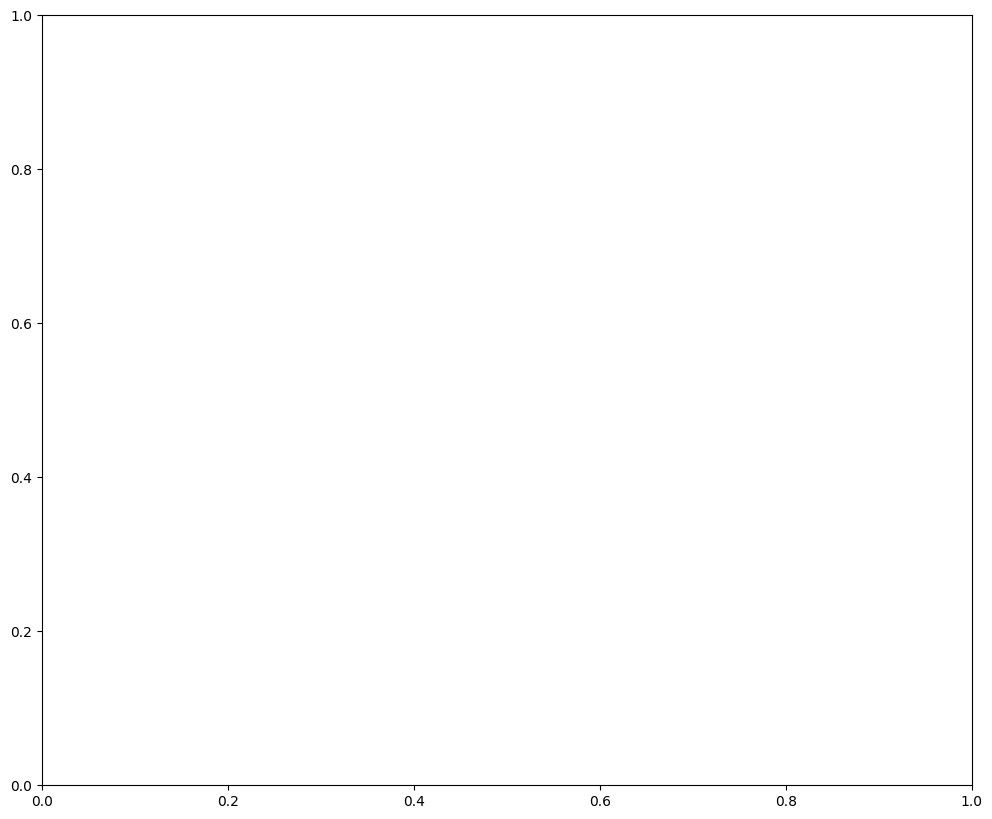

In [6]:
# Visualize segmented trajectories with contact/no-contact coloring
if segmented_dataset is not None and segment_metadata is not None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    n_to_plot = min(20, len(segmented_dataset))
    print(f"Visualizing {n_to_plot} segmented trajectories...")
    
    # Plot segments with different colors for contact/no-contact
    for i in range(min(20, len(segmented_dataset))):
        sample = segmented_dataset[i]
        trajectory = sample.trajectory  # Already numpy array, Shape: (T, 2)
        meta = segment_metadata[i]
        
        # Choose color based on contact
        if meta['contact_flag']:
            color = 'red'  # Contact segments in red
            alpha = 0.8
            linewidth = 2.0
        else:
            color = 'blue'  # No-contact segments in blue
            alpha = 0.6
            linewidth = 1.5
        
        # Plot trajectory
        ax.plot(trajectory[:, 0], trajectory[:, 1], 
                color=color, alpha=alpha, linewidth=linewidth)
        
        # Mark start and end points
        ax.scatter(trajectory[0, 0], trajectory[0, 1], 
                  color='green', marker='o', s=30, alpha=0.8)
        ax.scatter(trajectory[-1, 0], trajectory[-1, 1], 
                  color='red' if meta['contact_flag'] else 'blue', 
                  marker='s', s=30, alpha=0.8)
        
        # Add segment info as text (for first few segments)
        if i < 10:
            ax.text(trajectory[0, 0], trajectory[0, 1], 
                   f"E{meta['original_episode']}S{meta['segment_idx']}", 
                   fontsize=8, alpha=0.7)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', linewidth=2, label='Contact Segments'),
        Line2D([0], [0], color='blue', linewidth=1.5, label='No-Contact Segments'),
        Line2D([0], [0], marker='o', color='green', linestyle='None', markersize=8, label='Start'),
        Line2D([0], [0], marker='s', color='red', linestyle='None', markersize=8, label='End (Contact)'),
        Line2D([0], [0], marker='s', color='blue', linestyle='None', markersize=8, label='End (No-Contact)')
    ]
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'PushT Segmented Trajectories ({len(segmented_dataset)} segments)')
    ax.grid(True, alpha=0.3)
    ax.legend(handles=legend_elements)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
else:
    print("Segmented dataset not available for visualization")


Episode 0: 7 segments
Episode 1: 3 segments
Episode 2: 7 segments


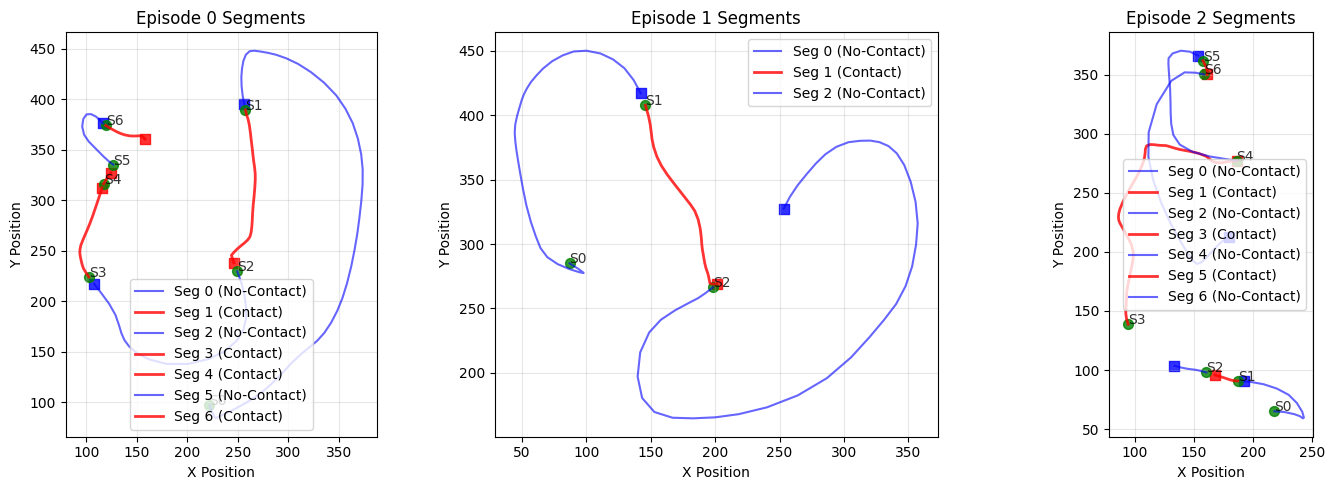

In [ ]:
# Visualize segments from specific episodes
if segmented_dataset is not None and segment_metadata is not None:
    # Group segments by original episode
    episode_segments = {}
    for i, meta in enumerate(segment_metadata):
        ep_idx = meta['original_episode']
        if ep_idx not in episode_segments:
            episode_segments[ep_idx] = []
        episode_segments[ep_idx].append((i, meta))
    
    # Show first few episodes
    episodes_to_show = sorted(episode_segments.keys())[:3]
    
    fig, axes = plt.subplots(1, len(episodes_to_show), figsize=(5*len(episodes_to_show), 5))
    if len(episodes_to_show) == 1:
        axes = [axes]
    
    for plot_idx, ep_idx in enumerate(episodes_to_show):
        ax = axes[plot_idx]
        segments = episode_segments[ep_idx]
        
        print(f"Episode {ep_idx}: {len(segments)} segments")
        
        for seg_idx, (sample_idx, meta) in enumerate(segments):
            sample = segmented_dataset[sample_idx]
            trajectory = sample.trajectory  # Already numpy array
            
            # Choose color based on contact
            if meta['contact_flag']:
                color = 'red'
                alpha = 0.8
                linewidth = 2.0
            else:
                color = 'blue'
                alpha = 0.6
                linewidth = 1.5
            
            # Plot trajectory
            ax.plot(trajectory[:, 0], trajectory[:, 1], 
                    color=color, alpha=alpha, linewidth=linewidth,
                    label=f'Seg {seg_idx} ({"Contact" if meta["contact_flag"] else "No-Contact"})')
            
            # Mark start and end points
            ax.scatter(trajectory[0, 0], trajectory[0, 1], 
                      color='green', marker='o', s=50, alpha=0.8)
            ax.scatter(trajectory[-1, 0], trajectory[-1, 1], 
                      color='red' if meta['contact_flag'] else 'blue', 
                      marker='s', s=50, alpha=0.8)
            
            # Add segment info
            ax.text(trajectory[0, 0], trajectory[0, 1], 
                   f"S{seg_idx}", fontsize=10, alpha=0.8)
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Episode {ep_idx} Segments')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
else:
    print("Segmented dataset not available for episode visualization")


=== SEGMENT ANALYSIS ===
Total segments: 1291
Contact segments: 608 (47.1%)
No-contact segments: 683 (52.9%)

Segment Length Statistics:
Contact segments - Mean: 18.1, Std: 12.3
No-contact segments - Mean: 20.7, Std: 8.4

Episodes with segments: 206
Segments per episode - Mean: 6.3, Max: 13, Min: 2


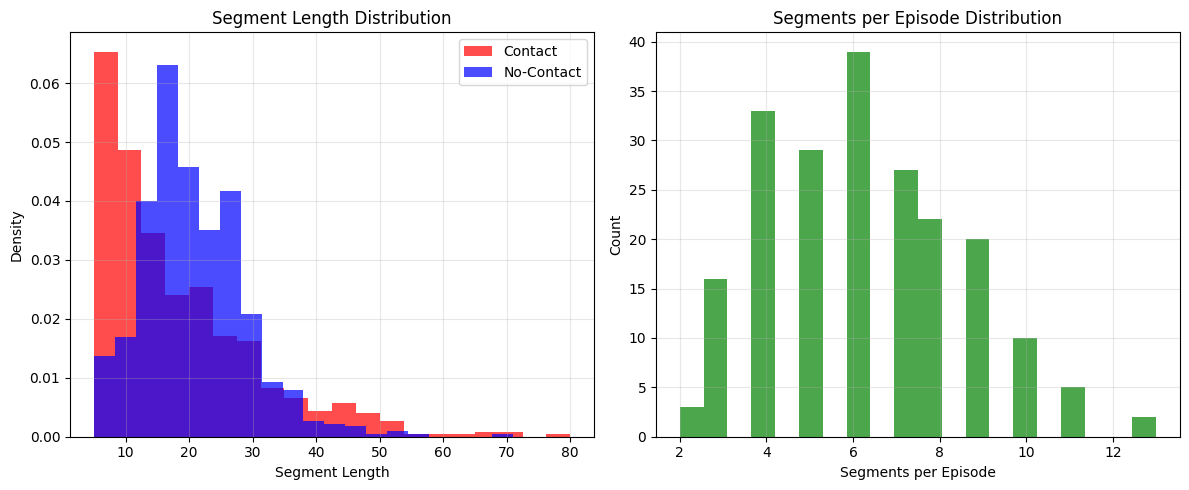


Example Segments:
  Segment 0: Episode 0, Segment 0, Contact: False, Length: 51
  Segment 1: Episode 0, Segment 1, Contact: True, Length: 27
  Segment 2: Episode 0, Segment 2, Contact: False, Length: 22
  Segment 3: Episode 0, Segment 3, Contact: True, Length: 19
  Segment 4: Episode 0, Segment 4, Contact: True, Length: 6


In [ ]:
# Analyze segment characteristics
if segmented_dataset is not None and segment_metadata is not None:
    print("=== SEGMENT ANALYSIS ===")
    
    # Basic statistics
    contact_segments = [m for m in segment_metadata if m['contact_flag']]
    no_contact_segments = [m for m in segment_metadata if not m['contact_flag']]
    
    print(f"Total segments: {len(segment_metadata)}")
    print(f"Contact segments: {len(contact_segments)} ({len(contact_segments)/len(segment_metadata)*100:.1f}%)")
    print(f"No-contact segments: {len(no_contact_segments)} ({len(no_contact_segments)/len(segment_metadata)*100:.1f}%)")
    
    # Length statistics
    contact_lengths = [m['segment_length'] for m in contact_segments]
    no_contact_lengths = [m['segment_length'] for m in no_contact_segments]
    
    print(f"\nSegment Length Statistics:")
    print(f"Contact segments - Mean: {np.mean(contact_lengths):.1f}, Std: {np.std(contact_lengths):.1f}")
    print(f"No-contact segments - Mean: {np.mean(no_contact_lengths):.1f}, Std: {np.std(no_contact_lengths):.1f}")
    
    # Episode statistics
    episodes = set(m['original_episode'] for m in segment_metadata)
    print(f"\nEpisodes with segments: {len(episodes)}")
    
    segments_per_episode = {}
    for m in segment_metadata:
        ep = m['original_episode']
        if ep not in segments_per_episode:
            segments_per_episode[ep] = 0
        segments_per_episode[ep] += 1
    
    print(f"Segments per episode - Mean: {np.mean(list(segments_per_episode.values())):.1f}, "
          f"Max: {max(segments_per_episode.values())}, Min: {min(segments_per_episode.values())}")
    
    # Visualize segment length distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Length distribution
    ax1.hist(contact_lengths, bins=20, alpha=0.7, color='red', label='Contact', density=True)
    ax1.hist(no_contact_lengths, bins=20, alpha=0.7, color='blue', label='No-Contact', density=True)
    ax1.set_xlabel('Segment Length')
    ax1.set_ylabel('Density')
    ax1.set_title('Segment Length Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Segments per episode
    episode_counts = list(segments_per_episode.values())
    ax2.hist(episode_counts, bins=20, alpha=0.7, color='green')
    ax2.set_xlabel('Segments per Episode')
    ax2.set_ylabel('Count')
    ax2.set_title('Segments per Episode Distribution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show some example segments with their metadata
    print(f"\nExample Segments:")
    for i in range(min(5, len(segment_metadata))):
        meta = segment_metadata[i]
        print(f"  Segment {i}: Episode {meta['original_episode']}, "
              f"Segment {meta['segment_idx']}, "
              f"Contact: {meta['contact_flag']}, "
              f"Length: {meta['segment_length']}")
else:
    print("Segmented dataset not available for analysis")


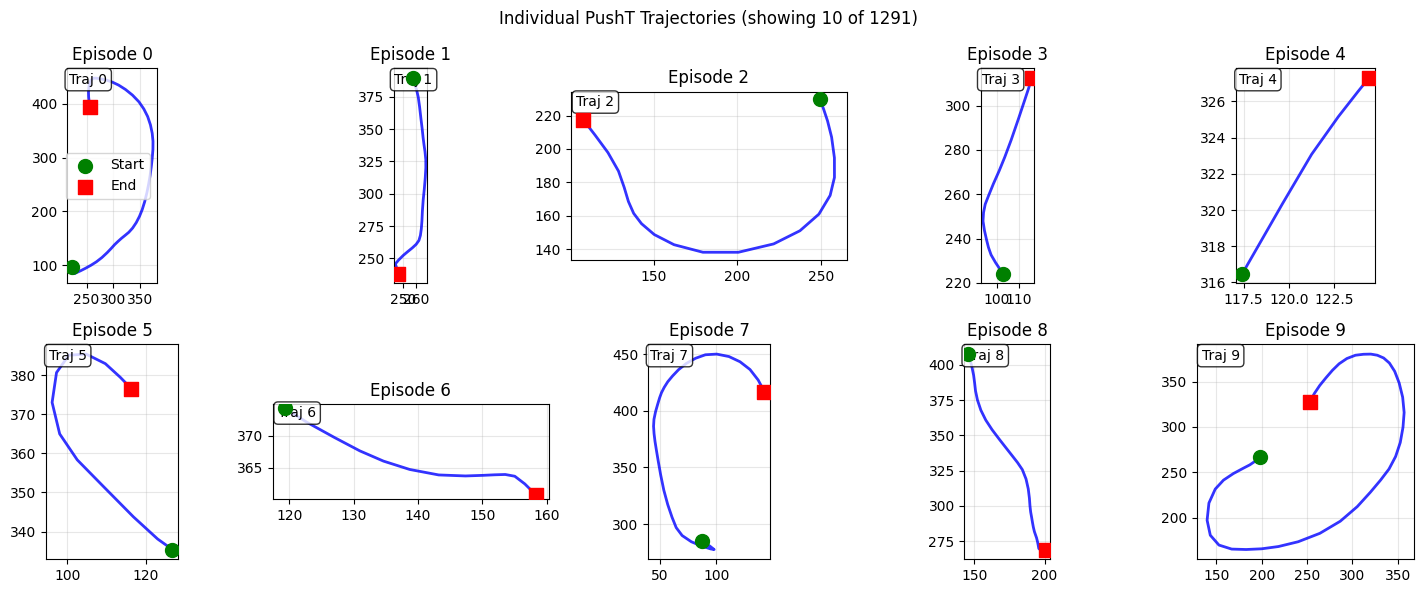

In [ ]:
# Visualize a subset of trajectories with more detail
n_show = min(10, len(segmented_dataset))
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(n_show):
    sample = segmented_dataset[i]
    trajectory = sample.trajectory
    
    ax = axes[i]
    ax.plot(trajectory[:, 0], trajectory[:, 1], 
            'b-', alpha=0.8, linewidth=2)
    ax.scatter(trajectory[0, 0], trajectory[0, 1], 
              color='green', marker='o', s=100, label='Start', zorder=5)
    ax.scatter(trajectory[-1, 0], trajectory[-1, 1], 
              color='red', marker='s', s=100, label='End', zorder=5)
    
    # Add trajectory index
    ax.text(0.02, 0.98, f'Traj {i}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(f'Episode {i}')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    if i == 0:
        ax.legend()

# Hide unused subplots
for i in range(n_show, len(axes)):
    axes[i].set_visible(False)

plt.suptitle(f'Individual PushT Trajectories (showing {n_show} of {len(segmented_dataset)})')
plt.tight_layout()
plt.show()


In [ ]:
# Environment-based rendering of segmented trajectories
def render_segment_with_env(segment_idx, original_dataset_path, render_mode="rgb_array", 
                           speed=1.0, save_images=False, output_dir=None):
    """
    Render a specific segment using the PushT environment.
    
    Args:
        segment_idx: Index of the segment to render
        original_dataset_path: Path to the original zarr dataset
        render_mode: "rgb_array" or "human"
        speed: Playback speed multiplier
        save_images: Whether to save rendered images
        output_dir: Directory to save images
    """
    from gym_pusht.envs.pusht import PushTEnv
    import zarr
    
    def apply_legacy_state(env, state):
        """Apply a state to the environment"""
        agent_pos = list(state[:2])
        block_pos = list(state[2:4])
        block_angle = float(state[4])
        
        env.agent.position = agent_pos
        env.block.position = block_pos
        env.block.angle = block_angle
        
        dt = getattr(env, "dt", 1.0 / getattr(env, "sim_hz", 100))
        env.space.step(dt)
    
    # Load the original dataset
    ds = zarr.open(original_dataset_path, 'r')
    episode_ends = ds['meta']['episode_ends'][:]
    
    # Get segment metadata
    meta = segment_metadata[segment_idx]
    episode_idx = meta['original_episode']
    seg_start = meta['original_start']
    seg_end = meta['original_end']
    
    # Calculate global indices
    episode_start = 0 if episode_idx == 0 else int(episode_ends[episode_idx - 1])
    global_start = episode_start + seg_start
    global_end = episode_start + seg_end
    
    # Load states
    states = ds['data']['state'][global_start:global_end]
    
    # Create environment
    env = PushTEnv(render_mode=render_mode, legacy=True)
    
    # Reset to first state
    options = {"reset_to_state": states[0]}
    obs, info = env.reset(options=options)
    
    print(f"Rendering segment {segment_idx} ({'Contact' if meta['contact_flag'] else 'No-Contact'})")
    print(f"  Episode: {episode_idx}, Length: {len(states)}")
    
    # Calculate timing
    dt = 1.0 / env.metadata.get("render_fps", 10)
    delay = dt / max(1.0, speed)
    
    images = []
    
    for t, state in enumerate(states):
        # Apply the state to the environment
        apply_legacy_state(env, state)
        
        # Render the current state
        if render_mode == "rgb_array":
            img = env.render()
            images.append(img)
        else:
            env.render()
            time.sleep(delay)
        
        # Print progress for long segments
        if len(states) > 50 and t % 10 == 0:
            print(f"  Progress: {t}/{len(states)}")
    
    env.close()
    
    # Save images if requested
    if save_images and output_dir and render_mode == "rgb_array":
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True)
        
        for t, img in enumerate(images):
            img_path = output_dir / f"segment_{segment_idx:03d}_frame_{t:03d}.png"
            plt.imsave(img_path, img)
        
        print(f"  Saved {len(images)} images to {output_dir}")
    
    return images, meta

# Test the rendering function
if segmented_dataset is not None and segment_metadata is not None:
    print("Testing environment rendering...")
    
    # Render a short segment (first few frames)
    try:
        images, meta = render_segment_with_env(
            segment_idx=0,
            original_dataset_path=os.path.join(REPO_ROOT, "datasets", "pusht_cchi_v7_replay.zarr.zip"),
            render_mode="rgb_array",
            save_images=True,
            output_dir="notebook_renders"
        )
        
        print(f"✓ Successfully rendered {len(images)} frames")
        print(f"  Segment type: {'Contact' if meta['contact_flag'] else 'No-Contact'}")
        print(f"  Episode: {meta['original_episode']}")
        print(f"  Length: {meta['segment_length']}")
        
    except Exception as e:
        print(f"✗ Error rendering segment: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Segmented dataset not available for rendering")


Testing environment rendering...


/home/x_alblo/.conda/envs/SD_pusht/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Rendering segment 0 (No-Contact)
  Episode: 0, Length: 51
  Progress: 0/51
  Progress: 10/51
  Progress: 20/51
  Progress: 30/51
  Progress: 40/51
  Progress: 50/51
  Saved 51 images to notebook_renders
✓ Successfully rendered 51 frames
  Segment type: No-Contact
  Episode: 0
  Length: 51


Creating animated GIFs with trajectory overlay...

=== Contact Segment 1 ===
Creating GIF for segment 1 (Contact)
  Episode: 0, Full Length: 27 frames
  Progress: 0/27
  Progress: 10/27
  Progress: 20/27
✓ GIF saved to: notebook_renders/contact_segment_1.gif
  Total frames: 27
  Duration: 2.7s @ 10 fps
Preview of first frame:


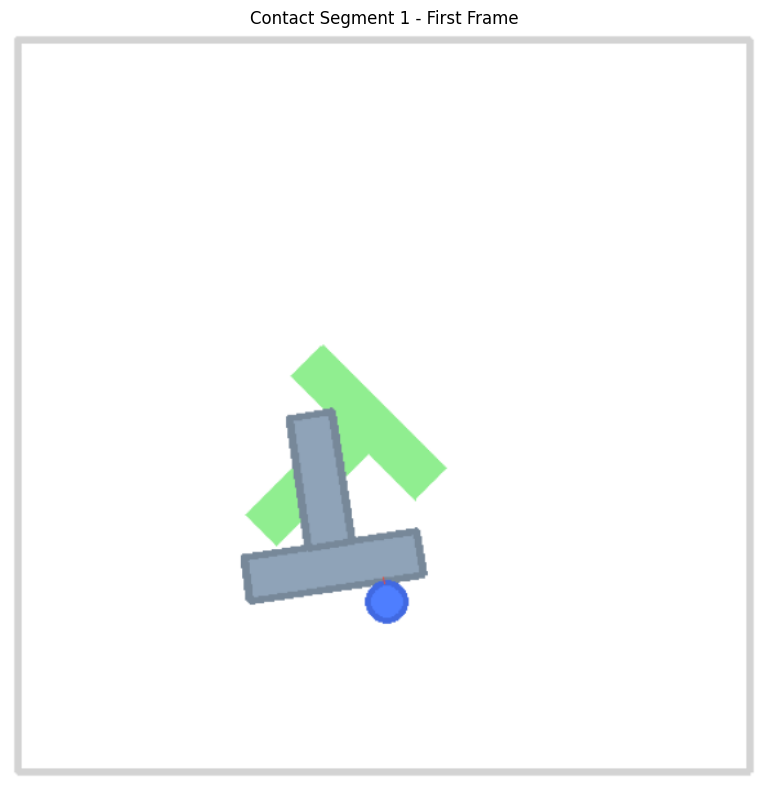


=== No-Contact Segment 0 ===
Creating GIF for segment 0 (No-Contact)
  Episode: 0, Full Length: 51 frames
  Progress: 0/51
  Progress: 10/51
  Progress: 20/51
  Progress: 30/51
  Progress: 40/51
  Progress: 50/51
✓ GIF saved to: notebook_renders/no_contact_segment_0.gif
  Total frames: 51
  Duration: 5.1s @ 10 fps
Preview of first frame:


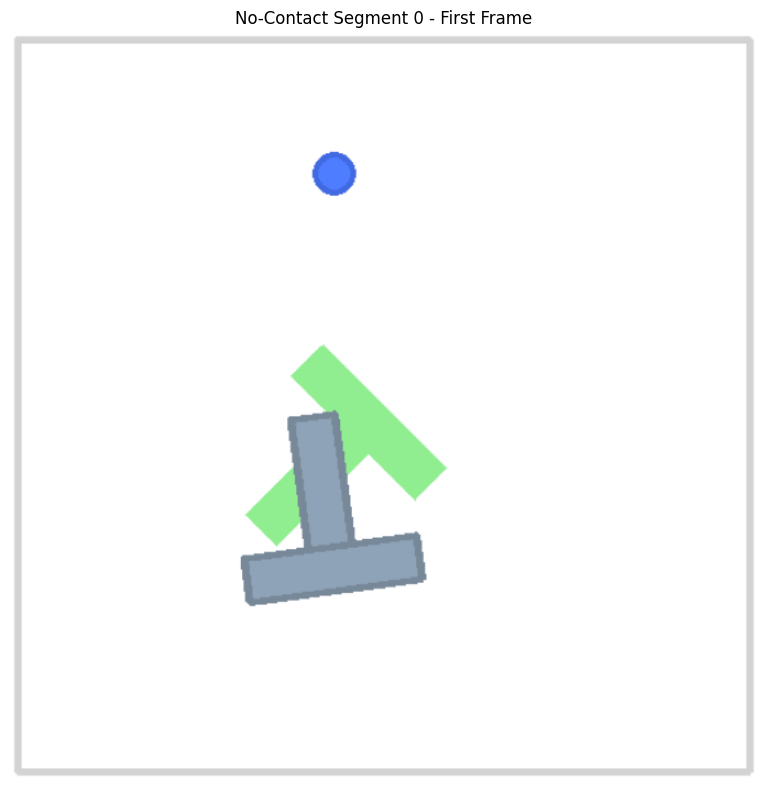

In [ ]:
# Create animated GIF with trajectory overlay
def create_segment_gif_with_trajectory(segment_idx, original_dataset_path, 
                                      output_path=None, fps=10, 
                                      trajectory_length=20, downsample=1):
    """
    Create an animated GIF showing a segment with trajectory overlay.
    
    Args:
        segment_idx: Index of the segment to render
        original_dataset_path: Path to the original zarr dataset
        output_path: Path to save the GIF (if None, use default)
        fps: Frames per second for the GIF
        trajectory_length: Number of past positions to show in trajectory
        downsample: Only use every Nth frame to reduce file size
    """
    from PIL import Image, ImageDraw
    from gym_pusht.envs.pusht import PushTEnv
    import zarr
    
    def apply_legacy_state(env, state):
        """Apply a state to the environment"""
        agent_pos = list(state[:2])
        block_pos = list(state[2:4])
        block_angle = float(state[4])
        
        env.agent.position = agent_pos
        env.block.position = block_pos
        env.block.angle = block_angle
        
        dt = getattr(env, "dt", 1.0 / getattr(env, "sim_hz", 100))
        env.space.step(dt)
    
    def world_to_pixel(pos, env_size=512, world_min=0, world_max=1):
        """Convert world coordinates to pixel coordinates"""
        # Assuming the render is 512x512 and world is [0,1] x [0,1]
        x = int((pos[0] - world_min) / (world_max - world_min) * env_size)
        y = int((1 - (pos[1] - world_min) / (world_max - world_min)) * env_size)  # Flip Y
        return (x, y)
    
    # Load the original dataset
    ds = zarr.open(original_dataset_path, 'r')
    episode_ends = ds['meta']['episode_ends'][:]
    
    # Get segment metadata
    meta = segment_metadata[segment_idx]
    episode_idx = meta['original_episode']
    seg_start = meta['original_start']
    seg_end = meta['original_end']
    
    # Calculate global indices
    episode_start = 0 if episode_idx == 0 else int(episode_ends[episode_idx - 1])
    global_start = episode_start + seg_start
    global_end = episode_start + seg_end
    
    # Load states
    states = ds['data']['state'][global_start:global_end]
    
    print(f"Creating GIF for segment {segment_idx} ({'Contact' if meta['contact_flag'] else 'No-Contact'})")
    print(f"  Episode: {episode_idx}, Full Length: {len(states)} frames")
    
    # Create environment
    env = PushTEnv(render_mode="rgb_array", legacy=True)
    
    # Reset to first state
    options = {"reset_to_state": states[0]}
    obs, info = env.reset(options=options)
    
    frames = []
    agent_trajectory = []
    
    for t in range(0, len(states), downsample):
        state = states[t]
        
        # Apply the state to the environment
        apply_legacy_state(env, state)
        
        # Render the current state
        img = env.render()
        
        # Convert to PIL Image for drawing
        pil_img = Image.fromarray(img)
        draw = ImageDraw.Draw(pil_img)
        
        # Track agent position
        agent_pos = state[:2]
        agent_trajectory.append(agent_pos)
        
        # Keep only recent trajectory
        if len(agent_trajectory) > trajectory_length:
            agent_trajectory = agent_trajectory[-trajectory_length:]
        
        # Draw trajectory
        if len(agent_trajectory) > 1:
            # Draw lines connecting trajectory points
            for i in range(len(agent_trajectory) - 1):
                p1 = world_to_pixel(agent_trajectory[i])
                p2 = world_to_pixel(agent_trajectory[i + 1])
                
                # Color gradient from old (faint) to new (bright)
                alpha = int(255 * (i + 1) / len(agent_trajectory))
                
                # Use different colors for contact vs no-contact
                if meta['contact_flag']:
                    color = (255, alpha, alpha)  # Red gradient for contact
                else:
                    color = (alpha, alpha, 255)  # Blue gradient for no-contact
                
                draw.line([p1, p2], fill=color, width=3)
            
            # Draw current position as a larger circle
            current_pixel = world_to_pixel(agent_trajectory[-1])
            draw.ellipse([current_pixel[0]-5, current_pixel[1]-5, 
                         current_pixel[0]+5, current_pixel[1]+5],
                        fill=(255, 255, 0), outline=(0, 0, 0))
        
        # Add text overlay
        contact_type = "CONTACT" if meta['contact_flag'] else "NO CONTACT"
        draw.text((10, 10), f"Segment {segment_idx} ({contact_type})", fill=(255, 255, 255))
        draw.text((10, 30), f"Frame {t}/{len(states)}", fill=(255, 255, 255))
        draw.text((10, 50), f"Episode {episode_idx}", fill=(255, 255, 255))
        
        frames.append(pil_img)
        
        if t % 10 == 0:
            print(f"  Progress: {t}/{len(states)}")
    
    env.close()
    
    # Save as GIF
    if output_path is None:
        output_path = f"segment_{segment_idx:03d}_{'contact' if meta['contact_flag'] else 'no_contact'}.gif"
    
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=int(1000/fps),
        loop=0
    )
    
    print(f"✓ GIF saved to: {output_path}")
    print(f"  Total frames: {len(frames)}")
    print(f"  Duration: {len(frames)/fps:.1f}s @ {fps} fps")
    
    return output_path, frames, meta

# Test the GIF creation
if segmented_dataset is not None and segment_metadata is not None:
    print("Creating animated GIFs with trajectory overlay...")
    
    # Create GIFs for a contact and no-contact segment
    contact_segments = [i for i, m in enumerate(segment_metadata) if m['contact_flag']]
    no_contact_segments = [i for i, m in enumerate(segment_metadata) if not m['contact_flag']]
    
    if contact_segments:
        print(f"\n=== Contact Segment {contact_segments[0]} ===")
        gif_path, frames, meta = create_segment_gif_with_trajectory(
            segment_idx=contact_segments[0],
            original_dataset_path=os.path.join(REPO_ROOT, "datasets", "pusht_cchi_v7_replay.zarr.zip"),
            output_path=f"notebook_renders/contact_segment_{contact_segments[0]}.gif",
            fps=10,
            trajectory_length=30,
            downsample=1  # Use all frames
        )
        
        # Display the first frame as a preview
        print(f"Preview of first frame:")
        plt.figure(figsize=(8, 8))
        plt.imshow(frames[0])
        plt.title(f"Contact Segment {contact_segments[0]} - First Frame")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    if no_contact_segments:
        print(f"\n=== No-Contact Segment {no_contact_segments[0]} ===")
        gif_path, frames, meta = create_segment_gif_with_trajectory(
            segment_idx=no_contact_segments[0],
            original_dataset_path=os.path.join(REPO_ROOT, "datasets", "pusht_cchi_v7_replay.zarr.zip"),
            output_path=f"notebook_renders/no_contact_segment_{no_contact_segments[0]}.gif",
            fps=10,
            trajectory_length=30,
            downsample=1  # Use all frames
        )
        
        # Display the first frame as a preview
        print(f"Preview of first frame:")
        plt.figure(figsize=(8, 8))
        plt.imshow(frames[0])
        plt.title(f"No-Contact Segment {no_contact_segments[0]} - First Frame")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
else:
    print("Segmented dataset not available for rendering")


In [ ]:
# Analyze trajectory statistics
print("Trajectory Statistics:")
print("=" * 50)

# Calculate trajectory lengths (excluding padding)
trajectory_lengths = []
start_positions = []
end_positions = []
trajectory_ranges = []

for i in range(len(segmented_dataset)):
    sample = segmented_dataset[i]
    trajectory = sample.trajectory
    
    # Find actual trajectory length (where agent stops moving significantly)
    # This is a heuristic - in practice you might have episode length info
    diff = np.linalg.norm(np.diff(trajectory, axis=0), axis=1)
    # Find where movement becomes very small (indicating end of episode)
    movement_threshold = 0.01
    if len(diff) > 0:
        last_movement_idx = np.where(diff > movement_threshold)[0]
        if len(last_movement_idx) > 0:
            actual_length = last_movement_idx[-1] + 1
        else:
            actual_length = len(trajectory)
    else:
        actual_length = len(trajectory)
    
    trajectory_lengths.append(actual_length)
    start_positions.append(trajectory[0])
    end_positions.append(trajectory[actual_length-1])
    
    # Calculate trajectory range
    x_range = np.max(trajectory[:actual_length, 0]) - np.min(trajectory[:actual_length, 0])
    y_range = np.max(trajectory[:actual_length, 1]) - np.min(trajectory[:actual_length, 1])
    trajectory_ranges.append([x_range, y_range])

trajectory_lengths = np.array(trajectory_lengths)
start_positions = np.array(start_positions)
end_positions = np.array(end_positions)
trajectory_ranges = np.array(trajectory_ranges)

print(f"Number of trajectories: {len(segmented_dataset)}")
print(f"Average trajectory length: {np.mean(trajectory_lengths):.1f} ± {np.std(trajectory_lengths):.1f}")
print(f"Min/Max trajectory length: {np.min(trajectory_lengths)} / {np.max(trajectory_lengths)}")
print(f"\nStart position range:")
print(f"  X: [{np.min(start_positions[:, 0]):.2f}, {np.max(start_positions[:, 0]):.2f}]")
print(f"  Y: [{np.min(start_positions[:, 1]):.2f}, {np.max(start_positions[:, 1]):.2f}]")
print(f"\nEnd position range:")
print(f"  X: [{np.min(end_positions[:, 0]):.2f}, {np.max(end_positions[:, 0]):.2f}]")
print(f"  Y: [{np.min(end_positions[:, 1]):.2f}, {np.max(end_positions[:, 1]):.2f}]")
print(f"\nTrajectory spatial range:")
print(f"  X range: {np.mean(trajectory_ranges[:, 0]):.2f} ± {np.std(trajectory_ranges[:, 0]):.2f}")
print(f"  Y range: {np.mean(trajectory_ranges[:, 1]):.2f} ± {np.std(trajectory_ranges[:, 1]):.2f}")


Trajectory Statistics:
Number of trajectories: 1291
Average trajectory length: 18.5 ± 10.3
Min/Max trajectory length: 4 / 63

Start position range:
  X: [29.82, 483.74]
  Y: [55.00, 508.36]

End position range:
  X: [18.16, 495.99]
  Y: [71.01, 510.68]

Trajectory spatial range:
  X range: 87.76 ± 71.21
  Y range: 90.71 ± 74.17


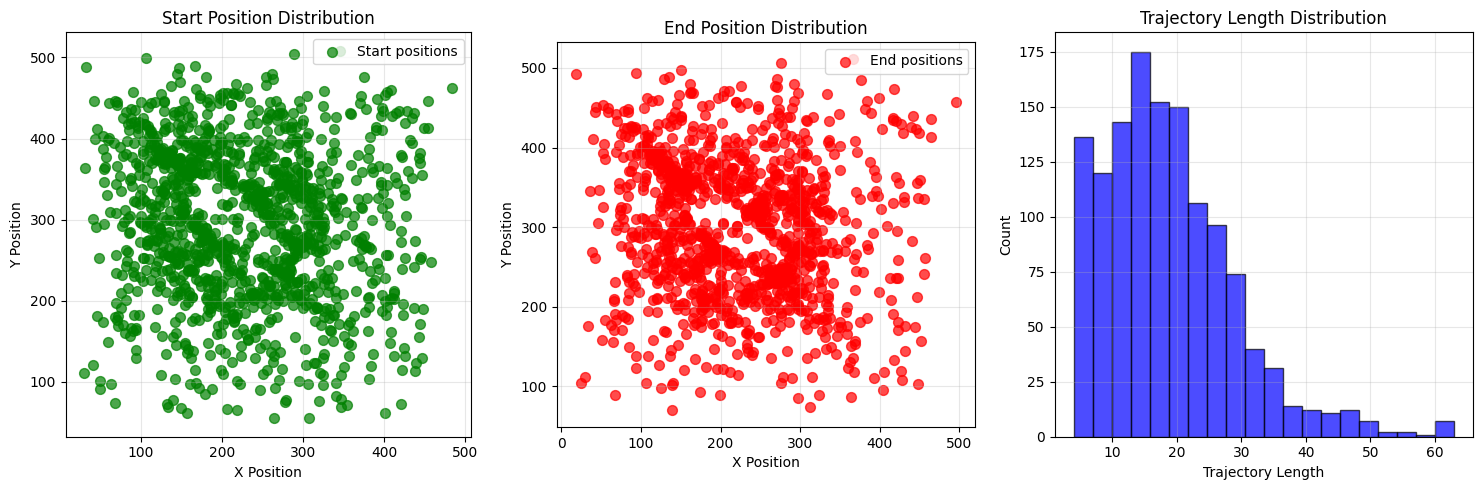

In [ ]:
# Visualize start and end position distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Start positions
axes[0].scatter(start_positions[:, 0], start_positions[:, 1], 
                alpha=0.7, s=50, color='green', label='Start positions')
axes[0].set_xlabel('X Position')
axes[0].set_ylabel('Y Position')
axes[0].set_title('Start Position Distribution')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_aspect('equal')

# End positions
axes[1].scatter(end_positions[:, 0], end_positions[:, 1], 
                alpha=0.7, s=50, color='red', label='End positions')
axes[1].set_xlabel('X Position')
axes[1].set_ylabel('Y Position')
axes[1].set_title('End Position Distribution')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_aspect('equal')

# Trajectory length distribution
axes[2].hist(trajectory_lengths, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[2].set_xlabel('Trajectory Length')
axes[2].set_ylabel('Count')
axes[2].set_title('Trajectory Length Distribution')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Summary and dataset info
print("PushT Dataset Summary")
print("=" * 50)
print(f"Dataset type: ToyDataset")
print(f"Total trajectories: {len(segmented_dataset)}")
print(f"Trajectory shape: {segmented_dataset.trajectories.shape}")
print(f"Feature dimension: {segmented_dataset.trajectories.shape[2]} (agent X, Y)")
print(f"Max trajectory length: {segmented_dataset.trajectories.shape[1]}")
print(f"\nDataset attributes:")
print(f"  - n_demos: {segmented_dataset.n_demos}")
print(f"  - demos: {len(segmented_dataset.demos)} demo IDs")
print(f"  - sequence_dataset: {segmented_dataset.sequence_dataset is not None}")

# Test dataset indexing
print(f"\nTesting dataset access:")
sample = segmented_dataset[0]
print(f"  - Sample type: {type(sample)}")
print(f"  - Sample trajectory shape: {sample.trajectory.shape}")
print(f"  - Sample demo_id: {sample.demo_id}")
print(f"  - Sample label_idx: {sample.label_idx}")
print(f"  - Sample start: {sample.start}")
print(f"  - Sample end: {sample.end}")


PushT Dataset Summary
Dataset type: ToyDataset
Total trajectories: 1291
Trajectory shape: (1291, 64, 2)
Feature dimension: 2 (agent X, Y)
Max trajectory length: 64

Dataset attributes:
  - n_demos: 1291
  - demos: 1291 demo IDs
  - sequence_dataset: True

Testing dataset access:
  - Sample type: <class 'SpatialDecomposition.TwoD_table_play.data.ToySample'>
  - Sample trajectory shape: (64, 2)
  - Sample demo_id: 0
  - Sample label_idx: -1
  - Sample start: [222.  97.]
  - Sample end: [256.50186 395.17484]
